<a target="_blank"  href="https://www.birmingham.ac.uk/schools/chemical-engineering/index.aspx"><img src="https://intranet.birmingham.ac.uk/staff/images/brand/download/jpg/crested-wm-full-colour.jpg" style="height:200px; display: block; margin-left: auto; margin-right: auto;"/></a>

# $M^2E^3D$ Workshop


---

#### Copyright 2023 The University of Birmingham, School of Chemical Engineering.
##### Authored by Andrei Leonard Nicusan.

Licensed under the GNU License, Version 3.0 (the "License").


The _Multiphase Materials Exploration via Evolutionary Equation Discovery_ - or $M^2E^3D$ / MED for short - is a toolkit for:
- Planning / designing experiments to gather as much information as possible for complex systems.
- Automatically discovering equations modelling the data acquired - simulated, experimental, past, current.
- Performing sensitivity analysis on measurements gathered.

This notebook is a hands-on introduction to using MED - first on data we generate, then on real measurements; each section contains explanations mixed with interactive code cells - you're encouraged to run and hack them!

# 0. Pre-requisites for this Notebook

Short version:
- [Install Visual Studio Code](https://code.visualstudio.com/).
- [Install Python in VS Code](https://code.visualstudio.com/docs/languages/python) - the "Installing packages" and "Jupyter notebooks" sections are useful.
- [Instal Julia in VS Code](https://www.julia-vscode.org/docs/dev/gettingstarted/).
- [Install the MED Python Library](https://github.com/uob-positron-imaging-centre/MED).

Long version: the only quirk of the library is that we need to install Julia beforehand - this is a modern, powerful programming language that resembles MATLAB, but is compiled to high-performance machine code (kinda like C/C++/Rust) - it's really lovely and I highly recommend it, but we won't need to write any Julia here. The [_symbolic regression_](https://github.com/MilesCranmer/SymbolicRegression.jl) engine that we use to derive equations automatically is written in Julia - which is why it's powerful enough to derive and fit millions of equations per second.

Visual Studio Code Users: you will need to download Julia and install the VS Code Julia plugin, then point it to the Julia folder. Please follow this short tutorial on setting it up: https://www.julia-vscode.org/docs/dev/gettingstarted/.

Terminal Users: if you're on Linux and prefer a more barebones setup, you can download Julia and add the <JuliaFolder>/bin directory to your PATH environment variable. There's no special advantage to this setup, so feel free to use the simpler VS Code approach.

Finally, install the MED library - in a terminal or Jupyter Notebook run:

```
TERMINAL> pip install git+https://github.com/uob-positron-imaging-centre/MED
JUPYTER> !pip install git+https://github.com/uob-positron-imaging-centre/MED
```

And in a code cell run the following Python code:

```python
import medeq
medeq.install()
```
    
We'll also be using Plotly to render some interactive graphs - run the following code to show them in this notebook:

In [1]:
# Set Plotly figure rendering
import plotly
plotly.io.renderers.default = "plotly_mimetype"      # or "browser"

# 1. Getting Data

Our data can:
- Be simulated or experimental
- Already exist from previous measurements, or future runs can be planned (à la DoE)
- Have many inputs affecting a few outputs

The mental format we're working with looks like a table, for example:

|              | <--        | _Varied Inputs_ | -->           | \| | _Measured Outputs_ | -->      |
|--------------|------------|-----------------|---------------|----|--------------------|----------|
|              | **Radius** | **Velocity**    | **Viscosity** | \| | **Pressure Drop**  | **Drag** |
| **Sample 1** | 0.91       | 0.77            | 3.09          | \| | 23.1               | 0.87     |
| **Sample 2** | 3.18       | 0.52            | 1.71          | \| | 0.71               | 0.39     |
| **...**      | ...        | ...             | ...           | \| | ...                | ...      |
| **Sample N** | 9.39       | 0.21            | 6.83          | \| | 0.13               | 0.53     |




No matter the data source, we need to tell MED what parameters to expect: some names, possible ranges (which can be expanded / modified later), and optionally names for the measured outputs. We stick all that in a `pandas.DataFrame` (if you're unfamiliar with this, it's kinda like Excel meets matrices); MED has a little helper function for creating this `parameters` object:

In [2]:
import medeq

parameters = medeq.create_parameters(
    ["A", "B"],
    minimums = [-6, -6],
    maximums = [6, 6],
)

# Note: in a Jupyter notebook the last expression is printed below
parameters

value  min  max
A    0.0 -6.0  6.0
B    0.0 -6.0  6.0

And now we can create a `medeq.MED` object from these `parameters`; when printed, it tells us all the relevant bits it keeps track of:

In [3]:
med = medeq.MED(parameters, seed = 123)
med

MED(seed=123)
---------------------------------------
parameters = 
     value  min  max
  A    0.0 -6.0  6.0
  B    0.0 -6.0  6.0
response_names = 
  None
---------------------------------------
sampler =   DVASampler(d=2, seed=123)
samples =   np.ndarray[(0, 2), float64]
responses = NoneType
epochs =    list[0, tuple[int, int]]

Let's take them one by one:
- Each `MED` object has a `seed` associated with it; when we use random numbers, we might want to have reproducible results, in which case we start extracting sequences of numbers from a "seeded distribution". This "seed" ensures each we run `MED` with the same seed we get the same results.
- The `parameters` object we saw above.
- The `response_names` which we can optionally define - i.e. names for the measured outputs.
- A `sampler`, which we'll explore in a sec, helping us plan future experiments (if we want to).
- The `samples` generated or introduced until now.
- The `responses` recorded.
- In cases where we run a few experiments, give results back to MED, then ask it to plan future runs, we keep track of the experimental batches, or `epochs`.

## 1.1. I already have data!

MED, unlike its authors, is not very opinionated: you can run measurements any way you want, simulated, experimental, following a design of experiments or whatever. The easiest case is when we already have data in the format:

|              | **Input 1** | **Input 2** | ... | **Input M** | \| | **Output** |
|--------------|-------------|-------------|-----|-------------|----|------------|
| **Sample 1** |             |             |     |             | \| |            |
| **Sample 2** |             |             |     |             | \| |            |
| **...**      |             |             |     |             | \| |            |
| **Sample N** |             |             |     |             | \| |            |


Then it's as simple as:
```python
import pandas as pd
data = pd.read_csv("filepath.csv")
```

## 1.2. Experimental planning - but first, why bother?

Suppose we have a process we want to investigate, for example:

- The mixing rate in a stirred tank with different viscosities and impeller speeds.
- The stability of a water-oil emulsion (e.g. a shampoo) with respect to surfactant concentration and oil content.
- The reaction rate in a gas-fluidised bed with varying gas flowrate and temperature.

In all cases above we have two inputs and one output; for each experiment we want to run, we choose an input combination (e.g. `20 Pa s` viscosity and `200 RPM` impeller speed), run the process and measure the output. We run a few experiments, and for each input combination tried we measure one output value.

As **experiments are time and money-consuming, we want to run as few of them as possible while extracting the most information available**. So how do we choose what input combinations to try? The general _Design of Experiments_ field is dedicated to this, for example:

- Classical Design of Experiments ("DoE") - one factor at a time, Box-Behnken, Plackett-Burman designs, etc.
- Lattice sampling - placing parameter combinations on a regular grid.
- Random sampling.

Will the experimental design affect our findings? How much? Let's see with an example: say we have the **budget to run 24 experiments** to investigate a **system with two inputs and one output**. To test our experimental designs, let's define the system response as a simple function:

$$f(A, B) = \sin(1.1 A) + \cos(0.5 B)$$
$$-6 < A, B < 6$$

**Remember that in reality we do not know our system response - that's exactly what we're investigating!** Here we're playing with a known test function to infer what we'd get in a real setting.

In [4]:
# Define an example function we'd like to investigate f(A, B) -> Output
# and the `parameters` object
import numpy as np
import medeq


def instrument(parameter_combination):
    a, b = parameter_combination
    return np.sin(1.1 * a) + np.cos(0.5 * b)


parameters = medeq.create_parameters(
    ["A", "B"],
    minimums = [-6, -6],
    maximums = [6, 6],
)

### 1.2.1. Full-Factorial / Lattice Sampling

The most general "classical design of experiments" is the full-factorial, where we try all possible parameter combinations; we specify the number of "levels", or subdivisions we want per input. For two inputs ("factors" in DoE parlance) and three levels, we'd get a $3 \times 3$ grid of parameters.

Let's try this: when creating a MED object you can define a `sampler` for different types of input parameter sampling. We then ask MED to generate 24 "samples" - i.e. parameter combinations to try. These are then added to a `queue` of experiments to run:

In [5]:
# Create MED object with a LatticeSampler and generate 24 samples to evaluate
med = medeq.MED(parameters, sampler = medeq.LatticeSampler, seed = 123)
samples = med.sample(24)

med

MED(seed=123)
-----------------------------------------
parameters = 
     value  min  max
  A    0.0 -6.0  6.0
  B    0.0 -6.0  6.0
response_names = 
  None
-----------------------------------------
sampler =   LatticeSampler(d=2, seed=123)
samples =   np.ndarray[(24, 2), float64]
responses = NoneType
epochs =    list[0, tuple[int, int]]

Notice the `samples =   np.ndarray[(24, 2), float64]` line, showing that we have generated a table of 24 samples, each with 2 parameter values.

[[-3.000003e+00 -6.000000e+00]
 [-6.000000e-06 -6.000000e+00]
 [ 2.999991e+00 -6.000000e+00]
 [ 5.999988e+00 -6.000000e+00]
 [-6.000000e+00 -3.000003e+00]] 
...


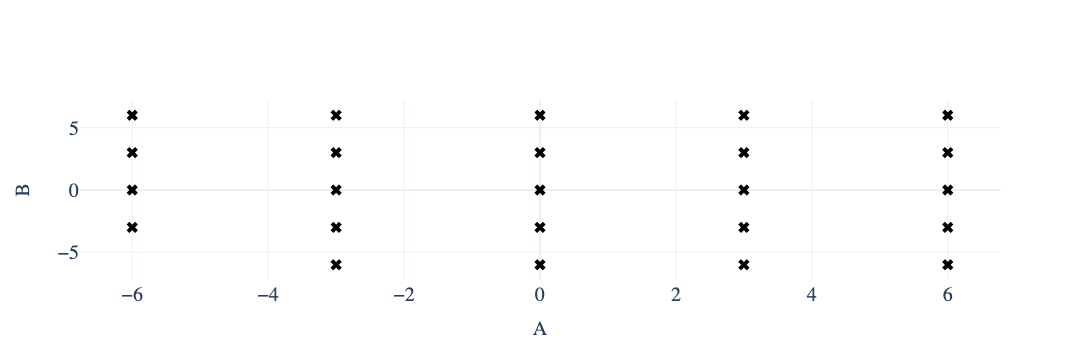

In [6]:
# Print first 5 samples, then plot their distribution
print(med.samples[:5], "\n...")
med.plot_samples()

We can take these parameter combinations and run our experiments, then feed our measured outputs back to MED:

In [7]:
# For each parameter combination in the `queue`, run the experiment - i.e. call the `instrument`
# function we defined above - and append the result to a list of `measurements`
measurements = []
for combination in med.queue:
    result = instrument(combination)
    measurements.append(result)

# Now give those evaluated measurements back to MED
med.evaluate(measurements)
med

MED(seed=123)
-----------------------------------------
parameters = 
     value  min  max
  A    0.0 -6.0  6.0
  B    0.0 -6.0  6.0
response_names = 
  response
-----------------------------------------
sampler =   LatticeSampler(d=2, seed=123)
samples =   np.ndarray[(24, 2), float64]
responses = np.ndarray[(24, 1), float64]
epochs =    list[1, tuple[int, int]]

MED has a state of the art probabilistic regression engine - Gaussian Processes - which fits our measured data points and tells us "how sure" we are of the fitted model:

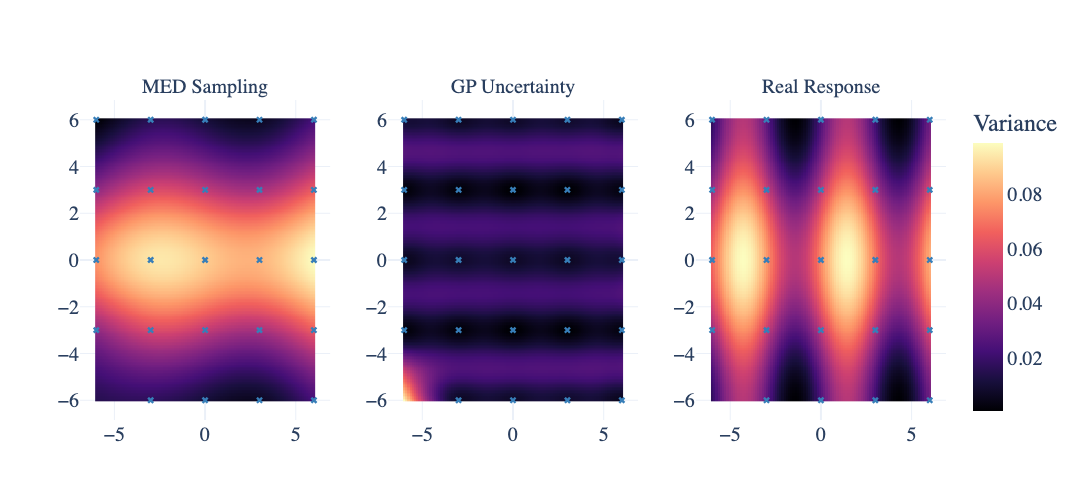

In [8]:
# Plot the fitted Gaussian Process model, its uncertainty and, if given (the `instrument` function) the real response
med.plot_response(instrument).update_layout(height = 500)

**Tasks**:

- How does the regressed model (left) compare to the real response (right)?
- Find the documentation for the `MED.sample` and `MED.evaluate` methods. What can they do?
- Try a different random seed, e.g. `seed = 16`. Do you notice any differences?

### 1.2.2. Random Sampling

Alright, so sampling at regular intervals can falsely impose a wrong shape onto the input data; what if we sample at _irregular_ intervals? Let's draw uniformly-distributed random samples across the parameter space:

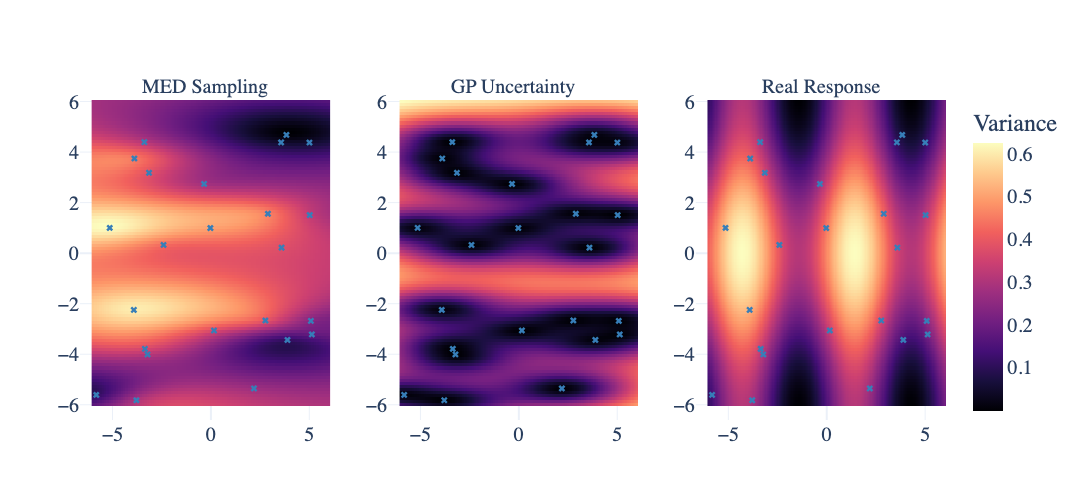

In [9]:
# Create MED object with a uniform random sampler
med = medeq.MED(parameters, sampler = medeq.RandomSampler, seed = 123)

# Generate samples and evaluate `instrument` function
med.sample(24)
med.evaluate(instrument)

# Plot samples, uncertainty, and real response
med.plot_response(instrument).update_layout(height = 500)

**Tasks**

- Notice the uncertainty around the samples tried - why is the response so chaotic?
- Try fewer / more samples - how does the fitted model change? When does it start to improve?

### 1.2.3. **DVA**Sampling - **D**iscrepancy-**V**ariance **A**daptive Sampling

What if we could place the parameter sampling points in a clever, well-spread out way? This is the first part of what the novel `DVASampler` does:

DVASampler | Fitness: 7.3013e-04 | Convergence: 1.7931e-07 : : : 900it [00:02, 305.92it/s]


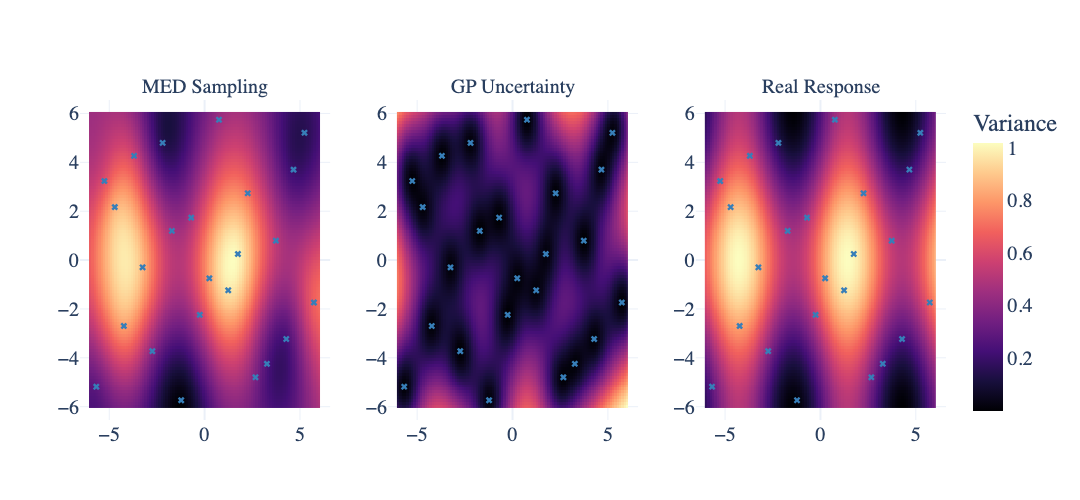

In [10]:
# Create MED object with a DVASampler (the default, so no need to specify it)
med = medeq.MED(parameters, seed = 123)

# Generate samples and evaluate `instrument` function
med.sample(24)
med.evaluate(instrument)

# Plot samples, uncertainty, and real response
med.plot_response(instrument).update_layout(height = 500)

**Tasks**

- Notice how the samples are spread out - how does it compare to previous samplers?
- How many samples did the `RandomSampler` need to achieve similar accuracy / uncertainty?

Now that we've measured a few data points, we see that there are a few regions with high uncertainty - we'd now like to run a few more experiments; how should we place the new samples? The second part of the `DVASampler` is that it can specifically target high uncertainty regions to get the most of new experiments:

DVASampler | Fitness: 5.0900e-03 | Convergence: 4.7904e-07 : : : 400it [00:00, 546.95it/s]


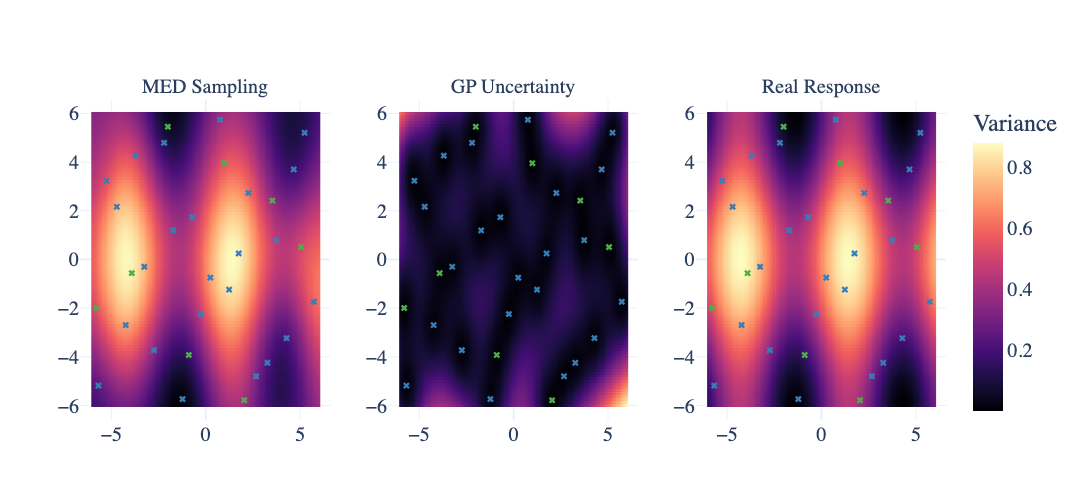

In [11]:
# Measure 8 new samples to complete our "experimental campaign"
med.sample(8)
med.evaluate(instrument)

med.plot_response(instrument).update_layout(height = 500)

Notice the "second epoch" of our experiments - the green points (hover over them!) - and how much the uncertainty decreased overall. Therefore, the **`DVASampler` targets high-uncertainty regions in our experiments while maximising point spread**.

# 2. Deriving Equations

It's as simple as `med.discover()`!

In [12]:
# Define an example function we'd like to investigate f(A, B) -> Output
# and create the `parameters` object
import numpy as np
import medeq


def instrument(parameter_combination):
    a, b = parameter_combination
    return np.sin(1.1 * a) + np.cos(0.5 * b)


parameters = medeq.create_parameters(
    ["A", "B"],
    minimums = [-6, -6],
    maximums = [6, 6],
)

# Create MED object with the given parameters
med = medeq.MED(parameters, seed = 123)

# Generate samples and evaluate `instrument` function
med.sample(24)
med.evaluate(instrument)

# Run equation discovery
equations = med.discover(
    binary_operators = ["+", "*"],
    unary_operators = ["sin"],
)

DVASampler | Fitness: 7.3013e-04 | Convergence: 1.7931e-07 : : : 900it [00:02, 361.18it/s]


/opt/homebrew/anaconda3/envs/med/lib/python3.10/site-packages/pysr/sr.py:1257: UserWarning:

Note: it looks like you are running in Jupyter. The progress bar will be turned off.

/opt/homebrew/anaconda3/envs/med/lib/python3.10/site-packages/pysr/julia_helpers.py:201: UserWarning:

Julia has already started. The new Julia options {'threads': 10, 'optimize': 3} will be ignored.



Started!

Cycles per second: 1.970e+05
Head worker occupation: 8.1%
Progress: 546 / 3200 total iterations (17.062%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.134e+00  1.050e-07  0.054148078
2           5.788e-01  6.725e-01  sin(A)
4           4.754e-01  9.841e-02  sin(A * 1.1200889)
6           4.567e-01  2.005e-02  (sin(A * 1.1235898) * 1.1993314)
7           4.448e-01  2.635e-02  sin(sin(A * 1.1487976) * 1.9601239)
8           3.737e-01  1.743e-01  sin(A * ((B * -0.029545395) + 1.0572685))
9           5.896e-02  1.847e+00  (sin(A) + sin((B * 0.5079444) + 1.5882883))
10          5.633e-02  4.554e-02  (sin(sin(A)) + sin((B * -0.51107764) + 1.5471689))
11          5.910e-09  1.607e+01  (sin(A * 1.0999882) + sin((B * 0.5000299) + 1.57079))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.980e+05
Head worker occupation: 5.6%
Progress: 1095 / 3200 total iterations (34.219%)
Hall of Fame:
-------

## 2.1. Nice piece of mumbo jumbo, what does it mean?

Alright, that was the baptism of fire - here's an idea of what's hapenning under the hood:

![MED-Building-Equation-Slide](https://github.com/uob-positron-imaging-centre/MED/blob/main/docs/source/_static/build-equation.png?raw=true)

In essence, we tell `SymbolicRegression.jl` what operators it is allowed to use, and it then evolves various expressions composed of parameters, constants, unary / binary operators, fits the constants to our data, and then improves the expressions iteratively.

As a reminder, we generated 24 data points based on the expression

$$f(A, B) = \sin(1.1 A) + \cos(0.5 B)$$
$$-6 < A, B < 6$$

We only let MED use addition, multiplication (`binary_operators = ["+", "*"]`) and a sine function (`unary_operators = ["sin"]`); we then evolve hundreds of equations, evaluate them, then print the best-performing ones *at each complexity level*. In other words, we sort our equations by complexity and print four columns:

- **Complexity** - how many operators are in the equation tree.
- **Loss** - measure of accuracy, the sum of residuals for our predictions; the lower, the better the fit.
- **Score** - a combined result of complexity (lower complexity = higher score) and loss (higher accuracy = higher score); the higher, the better the model.
- **Equation** - the equation evaluated, with fitted constants.

**Tasks**
- Go through the evolving epochs - what kind of equations is it deriving?
- What's the best equation and why? Did it find the $\cos(0.5 B)$ term?

## 2.2. What should I vary?

Okay, so what should you care about when evolving equations? `SymbolicRegression.jl` has about 80 knobs you can tune - thankfully, most have been fine-tuned and `MED` sets sensible defaults for the rest for industrial applications. The most important ones are below:

- `binary_operators` - operators taking two real numbers as input, e.g. addition, exponentiation.
- `unary_operators` - operators taking one real number as input, e.g. sine, logarithm.
- `maxsize` - maximum size of equations evolved.
- `niterations` - number of epochs to run; more epochs may improve equations further, but take longer.
- `populations` - number of populations of equations to evolve in parallel; larger populations try more equations, but take longer.

Here they are in a single code cell you can hack:

In [13]:
# Run equation discovery
equations = med.discover(
    binary_operators = ["+", "*"],
    unary_operators = ["sin"],
    maxsize = 30,
    niterations = 100,
    populations = 32,
)

/opt/homebrew/anaconda3/envs/med/lib/python3.10/site-packages/pysr/sr.py:1257: UserWarning:

Note: it looks like you are running in Jupyter. The progress bar will be turned off.

/opt/homebrew/anaconda3/envs/med/lib/python3.10/site-packages/pysr/julia_helpers.py:201: UserWarning:

Julia has already started. The new Julia options {'threads': 10, 'optimize': 3} will be ignored.



Started!

Cycles per second: 2.110e+05
Head worker occupation: 4.5%
Progress: 583 / 3200 total iterations (18.219%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.134e+00  1.050e-07  0.054227658
2           5.788e-01  6.725e-01  sin(A)
4           4.754e-01  9.841e-02  sin(A * 1.1200889)
6           4.567e-01  2.005e-02  (sin(A * 1.1235898) * 1.1993314)
7           4.443e-01  2.750e-02  sin(sin(A * 1.1470172) * 1.8533415)
8           3.555e-01  2.229e-01  sin(A * ((B * -0.039493583) + 1.0971867))
9           5.896e-02  1.797e+00  (sin(A) + sin((B * 0.507922) + 1.5883168))
10          5.633e-02  4.554e-02  (sin(sin(A)) + sin((B * 0.51107067) + 1.5944339))
11          4.207e-10  1.870e+01  (sin(A * 1.0999973) + sin((B * 0.50000376) + 1.570773))
15          3.944e-10  1.617e-02  (sin(A * 1.0999973) + sin(((B + (-0.001465449 * -0.001465449)) * 0.50000376) + 1.570773))

Press 'q' and then <enter> to stop execution early.

Cycl

**Tasks**
- How would you choose the operators? And how would you incorporate "bundled" parameters like dimensionless numbers, e.g. **Re**.
- Play with the parameters above; how do the equations and runtime change?
- Check out the `MED.discover` method documentation; what other parameters might be worth changing?

## 2.3. How to select a model?

Here we used a well-defined, analytical function to generate our toy data (thought it wasn't a simple function and we only had 24 data points to make it more difficult), so it is straightforward to select our best equation: the only one with a score of 17! In practice it is rare to see scores above 1.

**There is a tradeoff between complexity and accuracy** - and so what we normally end up with is a _family of equations_ at various complexity levels. In general, you'll have:

- At the top - incredibly simple, but not too accurate equations (linear / quadratic models, etc.)
- At the bottom - extremely complex, overfitting equations (e.g. `sin(sin(sin(x^x)))`)
- In the middle - "physical-looking" equations we need to judge.

Indeed, your engineering background is required when selecting an equation; here are some rules of thumb:

- Recognise parts of previous models in some expressions: for example, when developing drag models I can see a Stokes-like term in some equations - this makes physical sense and renders them more trustworthy.
- Mentally calculate equation behaviour towards limits or bonkers values: for example, we had 3 good fluidised bed models, but two of them had a singularity at 0 - and so only one of them was _mathematically_ sound.
- Plot all reasonable-looking equations (there are only a few) and note the behaviour around the edges / limits; they may unphysically "curl" towards infinity.
- Run the equation discovery multiple times and see persistent forms.
- Select the simplest equation that had an error below `1.5 * min_error`.

We can implement the last one; `med.discover` returns a table of equations we can analyse further like this:

| complexity | loss         | score    | equation    |
|------------|--------------|----------|-------------|
| 1          | 1.133832e+00 | 0.000000 | 0.054225795 |
| 2          | 5.787591e-01 | 0.672472 | sin(A)      |
| ...        | ...          | ...      | ...         |

In [14]:
# Extract all equations with accuracy within 1.5 of the minimum loss
min_loss = equations["loss"].min()
selected = equations[equations["loss"] < 1.5 * min_loss]

# Choose the first equation - i.e. the simplest one
best_equation = selected.iloc[0]
print(best_equation["equation"])

(sin(A * 1.0999973) + sin((B * 0.50000376) + 1.570773))


# 3. Sensitivity Analysis

You might have noticed that the first 5 equations above only had the $A$ parameter included (yup, go check!) - and that's because MED will naturally select only the most important parameters, so you can use it on processes where you don't know which measurements are useful; just throw everything at it.

If we look at the real equation, we see that $\sin(1.1 A)$ has a larger pre-factor than $\cos(0.5 B)$, and so the output is more _sensitive_ to $A$; in other words, smaller changes in the input $A$ yield larger changes in the output $f(A, B)$. This **sensitivity analysis** is a very important tool when investigating processes - and we can do it even without fitting a model.

*It's also the kind of low-effort high-reward thing you can show employers or stick in papers!* Give it all the data you already have, out comes a quantitative ranking of parameter importance.

**Bit of background**: you might have seen this in classical design of experiments, where you have main effects (how strongly $f$ varies with **either** $A$ **or** $B$) and interaction effects (how strongly $f$ varies with **both** $A$ **and** $B$). While nice for its time, it has some strong limitations:

- It assumes a quadratic-type response.
- It requires a specific placement of samples (e.g. full factorial design).
- If there is some dependency between inputs, it can (strongly) pollute results.

While this may work for extremely simple (or extremely simplified) phenomena, chemical engineering typically deals with highly complex, non-linear and noisy systems, from packed beds to formulations; we cannot assume a quadratic-type response, and we cannot always directly control the sampling (e.g. if we have online measurements from the past, or the process is indirectly controlled).

Modern sensitivity analysis algorithms overcome these limitations with very clever statistical formulations - though they can become quite difficult to follow, especially post-2010 ones. Importantly, we don't need to (and can't) know the innermost details of everything - we can just use external packages some experts have developed; much like we use NumPy or Matplotlib or even Excel without needing to know about CPU cache misses or OpenGL rendering.

Let's take a simpler function to test our sensitivity analysis on:

$$f(a, b) = 1.5 * a + 0.5 b$$

We know $a$ has an effect that's 3 times stronger than $b$; let's see what some sensitivity analysis algorithms say:

In [15]:
# Define an example function we'd like to investigate f(A, B) -> Output
# and create the `parameters` object
import numpy as np
import medeq


def instrument(parameter_combination):
    a, b = parameter_combination
    return 1.5 * a + 0.5 * b


parameters = medeq.create_parameters(
    ["A", "B"],
    minimums = [-6, -6],
    maximums = [6, 6],
)

# Create MED object with the given parameters
med = medeq.MED(parameters, seed = 123)

# Generate samples and evaluate `instrument` function
med.sample(24)
med.evaluate(instrument)

# Run sensitivity analysis
sensitivity = med.sensitivity(algorithm = "rbd_fast")

DVASampler | Fitness: 7.3013e-04 | Convergence: 1.7931e-07 : : : 900it [00:02, 327.36it/s]

         S1  S1_conf
A  0.997180      0.0
B  0.664279      0.0


## 3.1. What do these outputs mean?

In general, sensitivity analysis yields some **sensitivity indices** - numerical values that represent how important different parameters are relative to each other; they come in a several forms:

- First-order indices (`S1`): measures the contribution to the output variance by a single model input parameter alone.
- Second-order indices (`S2`): measures the contribution to the output variance caused by the interaction of two model inputs.
- Total-order index (`ST`): measures the contribution to the output variance caused by a model input, including both its first-order effects (the input varying alone) and all higher-order interactions.

We also get 95% confidence intervals (e.g. `S1_conf`) for each of our sensitivity indices; the more measurements we have, the better the confidence.

**Tasks**
- Use different sensitivity analysis algorithms - go to the `MED.sensitivity` documentation to see the available ones.
- How do the sensitivities change with fewer / more samples? Do they accurately capture $a$ and $b$'s relative importance?
- Use the HDMR algorithm to compute interaction effects; add an interaction term to the `instrument` function (e.g. `+ a * b`).
- Find the paper explaining the `delta` algorithm; hint: use the SALib documentation from the link in the `MED.sensitivity` doc.

# 4. Your Turn!

Use your own data and build a MED analysis pipeline - in general:

1. Load a CSV / Excel of your data (`pd.read_csv` / `pd.read_excel`)
2. Create a parameters object (e.g. `medeq.create_parameters`) and a MED object with it (`medeq.MED`).
3. Pass your data points to MED (check out `MED.augment`).
4. `MED.discover`
5. `MED.sensitivity`
6. Profit

Here's a simple code cell showing the complete interface to `MED` - feel free to copy and hack it:

In [16]:
import medeq
import numpy as np


# Create DataFrame of MED free parameters and their bounds
parameters = medeq.create_parameters(
    ["velocity", "viscosity", "radius"],
    minimums = [-9, -9, -9],
    maximums = [10, 10, 10],
)


def instrument(x):
    '''Example unknown "experimental response" - a complex non-convex function.
    '''
    return x[0] * np.sin(0.5 * x[1]) + np.cos(1.1 * x[2])


# Create MED object, keeping track of free parameters, samples and results
med = medeq.MED(parameters)

# Initial parameter sampling
med.sample(36)
med.evaluate(instrument)

# New sampling, targeting most uncertain parameter regions
med.sample(18)
med.evaluate(instrument)

# Add previous / manually-evaluated responses
med.augment([[0, 0, 0]], [1])

# Save all results to disk - you can load them anywhere with `medeq.MED.load(filepath)`
med.save("med_results")

# Discover underlying equation; tell MED what operators it may use
med.discover(
    binary_operators = ["+", "-", "*", "/"],
    unary_operators = ["cos"],
)

# Run sensitivity analysis on measurements
med.sensitivity(algorithm = "rbd_fast")

# Plot interactive 2D slices of responses and uncertainties
med.plot_gp()

DVASampler | Fitness: 9.9430e-04 | Convergence: 9.3554e-08 : : : 2000it [00:14, 141.80it/s]
DVASampler | Fitness: 9.1541e-04 | Convergence: 1.6684e-07 : : : 800it [00:03, 209.65it/s]


/opt/homebrew/anaconda3/envs/med/lib/python3.10/site-packages/pysr/sr.py:1257: UserWarning:

Note: it looks like you are running in Jupyter. The progress bar will be turned off.

/opt/homebrew/anaconda3/envs/med/lib/python3.10/site-packages/pysr/julia_helpers.py:201: UserWarning:

Julia has already started. The new Julia options {'threads': 10, 'optimize': 3} will be ignored.



Started!

Cycles per second: 1.600e+05
Head worker occupation: 5.4%
Progress: 440 / 3200 total iterations (13.750%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.676e+01  -1.000e-10  -0.009553914
2           1.549e+01  7.875e-02  cos(radius)
4           1.491e+01  1.903e-02  cos(radius / 0.21170594)
6           1.419e+01  2.457e-02  (cos(radius / 0.21170594) / 0.5429284)
9           1.389e+01  7.331e-03  (cos(viscosity * 2.49278) - (cos(radius) * -2.3732314))
10          1.329e+01  4.396e-02  (cos(radius) - (cos(velocity) / cos(radius / -1.6586573)))
11          1.228e+01  7.915e-02  (cos((0.8174076 - cos(radius)) * (radius / 1.4485735)) * 2.739602)
16          1.192e+01  5.881e-03  ((cos(radius) - ((cos(velocity) - 0.5900735) * cos((radius / 1.8486891) + 0.5900735))) * 2.624525)
18          1.117e+01  3.254e-02  ((cos(radius) - ((cos(velocity * 0.27167118) - 0.752346) * cos((radius / 1.8258747) + 1.3039007))) * 2.565969

You're encouraged to use any suitable measurements you might have, or use one of the datasets provided (which is real, useful data!):
- Pipe pressure drop: validate MED by (re)discovering the Darcy-Weisbach equation.
- Fluidised bed (+oil) minimum fluidisation velocity: discover novel correlation for the effect of oil on fluidisation from real lab experiments (thanks Dominik!).
- Ellipsoid drag correlation: difficult open area of research, finding a good correlation for the fluid drag acting on a rounded 3D particle; check what's happening as **Re** tends to zero!